## Customer Attrition Model

In [1]:
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical computations
import matplotlib.pyplot as plt  # For creating static, animated, and interactive visualizations
import seaborn as sns  # For statistical data visualization based on Matplotlib
from tabulate import tabulate  # For pretty-printing tabular data

from sklearn import metrics  # For model evaluation metrics
from sklearn.ensemble import RandomForestClassifier  # For building a random forest classifier
from sklearn.model_selection import train_test_split  # To split data into train and test sets
from sklearn.metrics import recall_score  # To calculate recall score for classification models
from sklearn.metrics import classification_report  # To generate classification performance report
from sklearn.metrics import confusion_matrix  # To create a confusion matrix for model evaluation
from sklearn.tree import DecisionTreeClassifier  # For building a Decision Tree classifier
from imblearn.combine import SMOTEENN  # For handling class imbalance using SMOTE and ENN
import pickle # For storing and loading Python objects

In [2]:
# Load dataset from CSV file
df = pd.read_csv(r"D:\Stuff\Data Science\Machine Learning Models\Customer_churn_model\WA_Fn-UseC_-Telco-Customer-Churn.csv")
# Display the first few rows of the dataframe
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


##### As it is obsererved in the EDA part 
- It is observed that `TotalCharges` is of type **object**, whereas it should be of type **float**.
- The `SeniorCitizen` column should ideally be of type **object** instead of **int64**, since it contains values `0` and `1`, which represent categories rather than numerical values. Changing the data type helps reduce confusion during calculations.
- All other column data types appear to be appropriate.

In [3]:
# Convert 'TotalCharges' column to numeric, coercing errors to NaN
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
# Convert 'SSeniorCitizen' column to categorical type
df.SeniorCitizen = df.SeniorCitizen.astype('category')
# Display the data types of each column again to confirm changes 
df.dtypes

customerID            object
gender                object
SeniorCitizen       category
Partner               object
Dependents            object
tenure                 int64
PhoneService          object
MultipleLines         object
InternetService       object
OnlineSecurity        object
OnlineBackup          object
DeviceProtection      object
TechSupport           object
StreamingTV           object
StreamingMovies       object
Contract              object
PaperlessBilling      object
PaymentMethod         object
MonthlyCharges       float64
TotalCharges         float64
Churn                 object
dtype: object

#### It is observed that the 'TotalCharges' column has some NaN values.( In EDA File )

In [4]:
# Drop rows with null values in any column
df.dropna(how = 'any', inplace = True)

In [5]:
# Create a new DataFrame to avoid modifying the original
new_df = df.copy()

In [6]:
# Define tenure group labels in 12-month intervals (e.g., '1 - 12', '13 - 24', ...)
labels = ["{0} - {1}".format(i, i + 11) for i in range(1, 72, 12)]

# Categorize 'tenure' into discrete bins using the defined intervals
# right=False → interval includes the left value and excludes the right (e.g., [1,13) )
new_df['tenure_group'] = pd.cut(new_df.tenure, bins=range(1, 80, 12), right=False, labels=labels)

# Display the distribution of customers across tenure groups
new_df['tenure_group'].value_counts()

tenure_group
1 - 12     2175
61 - 72    1407
13 - 24    1024
25 - 36     832
49 - 60     832
37 - 48     762
Name: count, dtype: int64

In [7]:
# Remove the 'tenure' and 'customerID' columns from the DataFrame 
new_df.drop(columns = ['customerID','tenure'], axis=1, inplace=True)
new_df.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,1 - 12
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,25 - 36
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1 - 12
3,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,37 - 48
4,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1 - 12


In [8]:
# Apply label encoding to churn column
new_df['Churn'] = np.where(new_df['Churn']=='Yes',1,0)
new_df.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,1 - 12
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,25 - 36
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,1 - 12
3,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,37 - 48
4,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,1 - 12


In [9]:
# Aplly label encoding to categorical columns
new_df_dummies = pd.get_dummies(new_df)
new_df_dummies = new_df_dummies.astype(int)
new_df_dummies.head()

,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_1 - 12,tenure_group_13 - 24,tenure_group_25 - 36,tenure_group_37 - 48,tenure_group_49 - 60,tenure_group_61 - 72
0,29,29,0,1,0,1,0,0,1,1,...,0,0,1,0,1,0,0,0,0,0
1,56,1889,0,0,1,1,0,1,0,1,...,0,0,0,1,0,0,1,0,0,0
2,53,108,1,0,1,1,0,1,0,1,...,0,0,0,1,1,0,0,0,0,0
3,42,1840,0,0,1,1,0,1,0,1,...,1,0,0,0,0,0,0,1,0,0
4,70,151,1,1,0,1,0,1,0,1,...,0,0,1,0,1,0,0,0,0,0


In [10]:
# Dropping the 'Churn' column to use all other columns as features
x = new_df_dummies.drop(columns = 'Churn',axis = 1)

# Extracting the 'Churn' column as the target variable
y = new_df_dummies['Churn']

In [11]:
# Display the shape of the feature set and target variable
print(x.shape)
print(y.shape)

(7032, 51)
(7032,)


##### Split test and train data

In [12]:
# Splitting the dataset into training and testing sets with a 70-30 split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

### Decision Tree Classifier

In [13]:
# Initializing a DecisionTreeClassifier model
model_dt = DecisionTreeClassifier(criterion="gini", random_state=42, max_depth=6, min_samples_leaf=8)

# - criterion="gini": The Gini impurity measure is used to split nodes.
# - random_state=42: Ensures reproducibility of results.
# - max_depth=6: Limits the depth of the tree to prevent overfitting.
# - min_samples_leaf=8: Ensures each leaf node has at least 8 samples to avoid overfitting.

In [14]:
# Fitting the DecisionTreeClassifier model to the training data
model_dt.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=8, random_state=42)

In [15]:
# Making predictions using the trained DecisionTreeClassifier model on the test data (x_test)
y_pred = model_dt.predict(x_test)
print(f"Total Rows: {y_pred.shape[0]}")
print(y_pred)

Total Rows: 1407
[1 0 0 ... 1 0 0]


In [16]:
# Evaluate model accuracy on the test set
print(f"Accuracy: {(model_dt.score(x_test, y_test))*100 :.2f} %")

Accuracy: 78.39 %


In [17]:
def pretty_classification_report(y_true, y_pred, labels=None):
    report = classification_report(y_true, y_pred, labels=labels)
    print("-" * 60)
    print(report)
    print("-" * 60)

# Display precision, recall, f1-score, and support for each class (0: No Churn, 1: Churn)
print(classification_report(y_test, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1039
           1       0.62      0.46      0.53       368

    accuracy                           0.78      1407
   macro avg       0.72      0.68      0.69      1407
weighted avg       0.77      0.78      0.77      1407



### Model Evaluation Insight

As you can see, the **accuracy** is relatively low. Since this is an **imbalanced dataset**, we shouldn't rely on accuracy as a performance metric. Accuracy can be misleading in such cases — it's often considered **"cursed"** when class distributions are skewed.

#### What should we focus on instead?
We need to evaluate the model using:
- **Precision**
- **Recall**
- **F1-score**

Especially for the **minority class (Class 1: Churned customers)**.

#### Observation:
- Precision, recall, and F1-score for churned customers are significantly low.
- This indicates the model is not effectively capturing the patterns related to customer churn.

---

### Next Step: Apply SMOTEENN
We'll now move ahead to apply **SMOTEENN**, a technique that combines:
- **SMOTE (Synthetic Minority Oversampling Technique)** to balance the minority class, and
- **ENN (Edited Nearest Neighbors)** to clean noisy samples

This should help improve model performance on the minority class.


In [18]:
# Apply SMOTEENN to balance the dataset by oversampling the minority class and cleaning noisy samples
sm = SMOTEENN()
x_smot, y_smot = sm.fit_resample(x, y)

In [19]:
# Split the resampled data into training and testing sets (80/20 split)
xr_train, xr_test, yr_train, yr_test = train_test_split(x_smot, y_smot, test_size=0.2)

In [20]:
# Initialize Decision Tree with specified hyperparameters on SMOTEENN data
model_dt_smote = DecisionTreeClassifier(criterion="gini", random_state=100, max_depth=6, min_samples_leaf=8)

In [21]:
# Train the Decision Tree model on the resampled training data
model_dt_smote.fit(xr_train, yr_train)

# Predict on the test set
yr_predict = model_dt_smote.predict(xr_test)

# Get accuracy score on resampled test data
model_score_r = model_dt_smote.score(xr_test, yr_test)
print(f"Model Score: {model_score_r:.2%}")

# Display classification report for precision, recall, f1-score
print(metrics.classification_report(yr_test, yr_predict))

Model Score: 95.48%
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       514
           1       0.96      0.96      0.96       636

    accuracy                           0.95      1150
   macro avg       0.95      0.95      0.95      1150
weighted avg       0.95      0.95      0.95      1150



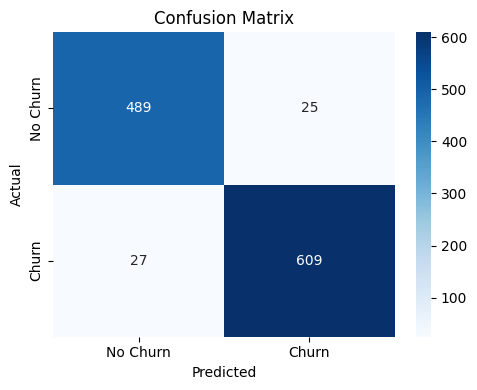

confusion_matrix:  
 [[489  25]
 [ 27 609]]


In [22]:
# Get the confusion matrix
cm = confusion_matrix(yr_test, yr_predict)

# Plot it using seaborn
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Display the confusion matrix for the resampled test set
print("confusion_matrix: ","\n",metrics.confusion_matrix(yr_test, yr_predict))

### Random Forest Classifier

In [23]:
# Initialize a Random Forest classifier with 100 trees, Gini index for splitting, and specific hyperparameters
model_rf = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=100, max_depth=6, min_samples_leaf=8)

In [24]:
# Fit the Random Forest model to the training data
model_rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=6, min_samples_leaf=8, random_state=100)

In [25]:
# Predict the target labels using the trained Random Forest model on the test data
y_pred = model_rf.predict(x_test)

In [26]:
# Evaluate the accuracy of the Random Forest model on the test data
print(f"Random forest Model Score: {model_rf.score(x_test, y_test):.2%}")

Random forest Model Score: 79.39%


In [27]:
# Generate and display the classification report for the Random Forest model's predictions
print(classification_report(y_test, y_pred, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1039
           1       0.64      0.48      0.55       368

    accuracy                           0.79      1407
   macro avg       0.74      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407



In [28]:
# Apply SMOTEENN (Synthetic Minority Over-sampling Technique + Edited Nearest Neighbors) to balance the dataset by generating synthetic samples and removing noise
x_smot1, y_smot1 = sm.fit_resample(x, y)

In [29]:
# Split the resampled dataset with 80% for training and 20% for testing
xrf_train, xrf_test, yrf_train, yrf_test = train_test_split(x_smot1, y_smot1, test_size=0.2)

In [30]:
# Initialize a RandomForestClassifier model with specified parameters
model_rf_smote = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=100, max_depth=6, min_samples_leaf=8)

# - 100 trees (n_estimators=100)
# - Gini impurity for splitting (criterion='gini')
# - Random state set to 100 for reproducibility
# - Maximum depth of the trees set to 6 (max_depth=6)
# - Minimum samples per leaf set to 8 (min_samples_leaf=8)

In [31]:
# Fit the Random Forest model on the resampled training data
model_rf_smote.fit(xrf_train, yrf_train)

RandomForestClassifier(max_depth=6, min_samples_leaf=8, random_state=100)

In [32]:
# Predict the target variable using the trained Random Forest model
yr_predict1 = model_rf_smote.predict(xrf_test)

In [33]:
# Evaluate the model's performance by calculating the accuracy on the resampled test set
model_score_r1 = model_rf_smote.score(xrf_test, yrf_test)
print(f"Random Forest Model Score: {model_score_r1:.2%}") # Print the model's accuracy score on the resampled test set

Random Forest Model Score: 94.02%


In [34]:
# Print the classification report to evaluate precision, recall, f1-score, etc., for each class
print(metrics.classification_report(yrf_test, yr_predict1))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93       545
           1       0.92      0.97      0.94       608

    accuracy                           0.94      1153
   macro avg       0.94      0.94      0.94      1153
weighted avg       0.94      0.94      0.94      1153



In [35]:
# Print the confusion matrix to evaluate the performance of the model on the resampled test set
print(metrics.confusion_matrix(yrf_test, yr_predict1))

[[496  49]
 [ 20 588]]


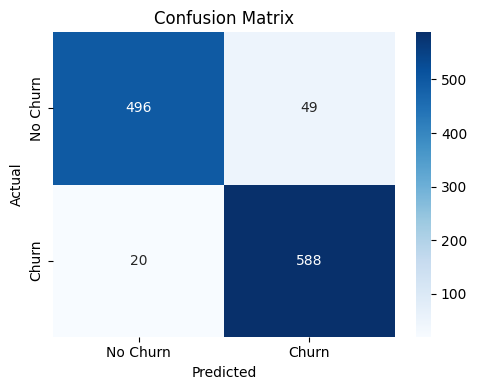

confusion_matrix:  
 [[496  49]
 [ 20 588]]


In [36]:
# Get the confusion matrix
cm1 = confusion_matrix(yrf_test, yr_predict1)

# Plot it using seaborn
plt.figure(figsize=(5,4))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Display the confusion matrix for the resampled test set
print("confusion_matrix: ","\n",metrics.confusion_matrix(yrf_test, yr_predict1))

### Save the model

In [37]:
# Save the trained Random Forest model with SMOTEENN applied to a file using pickle
filename = 'churn.model'
# filename = 'model.sav' # Define the filename for saving the model
pickle.dump(model_rf_smote, open(filename, 'wb'))

##### Open loaded Model to check 

In [38]:
# Load the previously saved Random Forest model from the file
load_model = pickle.load(open(filename, 'rb'))

# Evaluate the loaded model's performance on the test data
print(f"Model Score: {load_model.score(xrf_test, yrf_test):.2%}")

Model Score: 94.02%


**Our final model, i.e., the RF Classifier with SMOTEENN, is now ready and saved in the file `churn.model`. We will use this model to prepare APIs, enabling us to access it from the UI.**

In [39]:
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split

# # Separate features and target
# X = new_df.drop('Churn', axis=1)
# y = new_df['Churn']  # Already encoded as 1/0

# # Identify categorical and numeric columns
# cat_cols = X.select_dtypes(include='object').columns.tolist()
# num_cols = X.select_dtypes(exclude='object').columns.tolist()

# # Build preprocessing pipeline
# preprocessor = ColumnTransformer(transformers=[
#     ('cat', OneHotEncoder(drop='first'), cat_cols),  # drop='first' to avoid dummy trap
#     ('num', 'passthrough', num_cols)
# ])

# # Combine preprocessing + model in a full pipeline
# clf_pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('classifier', RandomForestClassifier(random_state=42))
# ])

# # Split data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Fit the pipeline
# clf_pipeline.fit(X_train, y_train)

# # Predict on new data
# y_pred = clf_pipeline.predict(X_test)

In [40]:
# from sklearn.pipeline import Pipeline
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.tree import DecisionTreeClassifier
# import joblib

# # Assuming you already trained your model/pipeline
# pipe = Pipeline([
#     ('clf', RandomForestClassifier())
# ])

# pipe.fit(xr_train1, yr_train1)

# # Save it
# joblib.dump(pipe, 'model.sav')
# print("✅ Model saved successfully!")\

In [41]:
# import joblib
# model = joblib.load('model.sav')
# print(type(model))  # It should be <class 'sklearn.ensemble.RandomForestClassifier'>